## 1. Introduction

### Project Overview

This project investigates Martian atmospheric behavior using time series modeling and anomaly detection techniques, leveraging REMS (Rover Environmental Monitoring Station) data collected by the **Curiosity rover** at Gale Crater. The primary goals are:

- To develop robust models for forecasting **average ground temperature** on Mars using statistical and deep learning methods.
- To implement a hybrid anomaly detection system that identifies **atypical atmospheric behavior** based on residual analysis from forecast models.

These analyses are designed to support future scientific interpretation and autonomous monitoring of environmental events on Mars.

---

### Dataset Description

- **Source**: NASA REMS archive, derived from the Curiosity Rover’s environmental sensors.
- **Total Records**: 3,197 sols (Martian days), spanning multiple Martian years.
- **Key Features**:
  - `Ls`: Solar longitude (0°–360°), indicating Mars’ orbital position.
  - `mars_year`, `mars_month`, `mars_season`: Derived temporal features to capture Martian calendar cycles.
  - `avg_ground_temp`, `avg_air_temp`: Daily average temperatures near the surface and in the air.
  - `mean_pressure`: Atmospheric pressure in Pascals.
  - `UV_Radiation`: Categorical UV index (Low, Moderate, High, etc.).
  - `day_length`: Duration of the Martian sol in minutes.

**Note**: Some original columns (e.g., `sunrise`, `sunset`, `max_air_temp`) were dropped during preprocessing due to missing values or redundancy.

---

### Modeling Objective

The project focuses on **univariate and multivariate time series forecasting** of average ground temperature, followed by **residual-based anomaly detection** using LSTM autoencoders. Models are evaluated for predictive performance and anomaly sensitivity, with the ultimate aim of identifying patterns that could inform future **scientific exploration or onboard diagnostics** in planetary missions.



---

## 2. Data Overview

In [1]:
import os
import sys
import joblib
import json
import itertools
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.stderr = open(os.devnull, "w")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from utils.hybrid_anomaly_util import *
from utils.utilities import save_model_outputs, load_model_outputs
from utils.utilities import CombinedSequence

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical, Sequence

E0000 00:00:1747303993.796152 1073888 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747303993.798784 1073888 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747303993.806454 1073888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747303993.806463 1073888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747303993.806464 1073888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747303993.806465 1073888 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Project directory configuration
DATA_PATH     = "../data/processed"
MODEL_PATH    = "../models/"
LOG_PATH_ROOT = "../logs/"

### 2.1 Load and Inspect Data

In [3]:
# --- Unscaled data ---
X_unscaled_train = pd.read_csv(
    os.path.join(DATA_PATH, "unscaled_train.csv"),
    index_col='sol_number'
)
X_unscaled_test  = pd.read_csv(
    os.path.join(DATA_PATH, "unscaled_test.csv"),
    index_col='sol_number'
)

# Primary target series (ground temperature)
y_train = X_unscaled_train['avg_ground_temp']
y_test  = X_unscaled_test['avg_ground_temp']

In [4]:
X_unscaled_train.head()

,avg_air_temp,avg_ground_temp,mean_pressure,day_length,sin_lon,cos_lon,mars_season_spring,mars_season_summer,mars_season_winter,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high
sol_number,,,,,,,,,,,,
1,-37.5,-45.5,739.0,712.0,0.500000,-0.866025,0,0,1,0,0,1
9,-37.5,-45.5,739.0,714.0,0.422618,-0.906308,0,0,1,0,0,1
10,-37.5,-45.5,739.0,714.0,0.422618,-0.906308,0,0,1,0,0,1
11,-37.0,-43.5,740.0,713.0,0.406737,-0.913545,0,0,1,0,0,1
12,-37.0,-47.0,741.0,713.0,0.406737,-0.913545,0,0,1,0,0,1


In [5]:
X_unscaled_test.head()

,avg_air_temp,avg_ground_temp,mean_pressure,day_length,sin_lon,cos_lon,mars_season_spring,mars_season_summer,mars_season_winter,UV_Radiation_low,UV_Radiation_moderate,UV_Radiation_very_high
sol_number,,,,,,,,,,,,
2695,-32.5,-40.0,712.0,715.0,0.325568,-0.945519,0,0,1,0,1,0
2696,-33.5,-36.5,713.0,715.0,0.325568,-0.945519,0,0,1,0,1,0
2697,-35.0,-35.5,716.0,716.0,0.309017,-0.951057,0,0,1,0,1,0
2698,-33.0,-39.5,715.0,716.0,0.292372,-0.956305,0,0,1,0,1,0
2699,-31.5,-37.0,715.0,715.0,0.292372,-0.956305,0,0,1,0,0,0


In [6]:
print(f"Unscaled training set shape : {X_unscaled_train.shape}")
print(f"Unscaled test set shape  : {X_unscaled_test.shape}")

Unscaled training set shape : (2557, 12)
Unscaled test set shape  : (640, 12)


In [7]:
print("Training Set Info")
print("---" * 30)
print(X_unscaled_train.info())

Training Set Info
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 1 to 2694
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_air_temp            2557 non-null   float64
 1   avg_ground_temp         2557 non-null   float64
 2   mean_pressure           2557 non-null   float64
 3   day_length              2557 non-null   float64
 4   sin_lon                 2557 non-null   float64
 5   cos_lon                 2557 non-null   float64
 6   mars_season_spring      2557 non-null   int64  
 7   mars_season_summer      2557 non-null   int64  
 8   mars_season_winter      2557 non-null   int64  
 9   UV_Radiation_low        2557 non-null   int64  
 10  UV_Radiation_moderate   2557 non-null   int64  
 11  UV_Radiation_very_high  2557 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 259.

In [8]:
print("Test Set Info")
print("---" * 30)
print(X_unscaled_test.info())

Test Set Info
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 2695 to 3368
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_air_temp            640 non-null    float64
 1   avg_ground_temp         640 non-null    float64
 2   mean_pressure           640 non-null    float64
 3   day_length              640 non-null    float64
 4   sin_lon                 640 non-null    float64
 5   cos_lon                 640 non-null    float64
 6   mars_season_spring      640 non-null    int64  
 7   mars_season_summer      640 non-null    int64  
 8   mars_season_winter      640 non-null    int64  
 9   UV_Radiation_low        640 non-null    int64  
 10  UV_Radiation_moderate   640 non-null    int64  
 11  UV_Radiation_very_high  640 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 65.0 K

---

## 3. Forecast Modelling

### 3.1 Configuring Grid Search for Hyperparameter Optimization

In [9]:
# Hyperparameter grid setup
# Non-seasonal (p, d, q) options: AR terms, differencing, MA terms
p = range(0, 3)   # AR order: 0–2
d = range(0, 2)   # Differencing: 0–1
q = range(0, 3)   # MA order: 0–2
pdq_grid = [
    (x, y, z)
    for x in p for y in d for z in q
    if (x, y, z) != (0, 0, 0)   # exclude degenerate model
]

# Seasonal parameters: (P, D, Q) at each period s
seasonal_periods   = [5,10,15,20,25,30,35] 
P = Q = [0, 1]                 # Seasonal AR/MA terms
D = [1]                        # Seasonal differencing
seasonal_pdq_grid = [
    (X, Y, Z)
    for X in P for Y in D for Z in Q
]

In [10]:
def search_best_seasonal_model(
    y_train: pd.Series,
    y_test: pd.Series,
    pdq_grid: list,
    seasonal_pdq_grid: list,
    seasonal_periods: list,
    exog_train: pd.DataFrame = None,
    exog_test: pd.DataFrame  = None,
    model_type: str          = "SARIMA",
    log_path: str            = None
):
    """
    Perform a serial grid search over SARIMA/SARIMAX hyperparameters.

    For each combination of (p,d,q) × (P,D,Q,s), fits a SARIMAX model,
    evaluates it on the hold-out series, and selects the best model by
    lowest RMSE (ties broken by AIC). Logs all AIC/MAE/RMSE results
    to a file and returns both the best-model metadata and a list of
    all tested configurations.

    Parameters:
        y_train (pd.Series): Training target series.
        y_test  (pd.Series): Test target series for out-of-sample evaluation.
        pdq_grid (list): List of non-seasonal (p,d,q) tuples.
        seasonal_pdq_grid (list): List of seasonal (P,D,Q) tuples (excl. period).
        seasonal_periods (list): List of seasonal period lengths to evaluate.
        exog_train (pd.DataFrame, optional): Exogenous regressors for training.
        exog_test  (pd.DataFrame, optional): Exogenous regressors for testing.
        model_type (str): Identifier used in logs and output filenames.
        log_path (str, optional): Path to log file. If None, defaults to
            {LOG_PATH_ROOT}/{model_type}_search.log.

    Returns:
        best_result (dict): {
            'seasonal_period', 'order', 'seasonal_order', 'aic',
            'mae', 'rmse', 'model', 'residuals'
        }
        all_models (list of dict): Metadata for every tested configuration.
    """
    # Ensure output directories exist
    os.makedirs(LOG_PATH_ROOT, exist_ok=True)
    os.makedirs(MODEL_PATH,    exist_ok=True)

    # Default log filename if none provided
    if log_path is None:
        log_path = os.path.join(
            LOG_PATH_ROOT,
            f"{model_type.lower()}_search.log"
        )

    # Initialize best‐model trackers
    best_rmse     = np.inf
    best_aic      = np.inf
    best_mae      = np.inf
    best_model    = None
    best_order    = None
    best_seasonal = None
    best_period   = None

    all_models = []

    # Compute total fits for tqdm bar
    total_fits = sum(
        1
        for s in seasonal_periods
        for order in pdq_grid
        for season in seasonal_pdq_grid
        if order != (0, 0, 0)
    )

    # Open log and progress bar
    with open(log_path, "w") as log_file, \
         tqdm(total=total_fits, desc=f"{model_type} grid search") as pbar:

        # Write header
        log_file.write(f"{model_type} Grid Search Log\n")
        log_file.write(f"{'='*60}\n")
        log_file.write(f"Started at: {datetime.now():%Y-%m-%d %H:%M:%S}\n")
        log_file.write(f"Seasonal periods: {seasonal_periods}\n\n")

        # Iterate through every hyperparameter combination
        for s in seasonal_periods:
            for order in pdq_grid:
                for season in seasonal_pdq_grid:

                    # Skip degenerate model
                    if order == (0, 0, 0):
                        pbar.update()
                        continue

                    try:
                        # Fit SARIMAX (or SARIMA if exog_train is None)
                        model = SARIMAX(
                            y_train,
                            exog=exog_train,
                            order=order,
                            seasonal_order=season + (s,)
                        )
                        result = model.fit(disp=False, maxiter=50)

                        # Evaluate: AIC (in-sample), then MAE/RMSE (out-of-sample)
                        aic   = result.aic
                        fc    = result.get_forecast(
                            steps=len(y_test),
                            exog=exog_test
                        )
                        y_pred = fc.predicted_mean
                        mae   = mean_absolute_error(y_test, y_pred)
                        rmse  = np.sqrt(mean_squared_error(y_test, y_pred))

                        # Record in full grid log
                        all_models.append({
                            "seasonal_period": s,
                            "order": order,
                            "seasonal_order": season,
                            "aic": aic,
                            "mae": mae,
                            "rmse": rmse
                        })
                        log_file.write(
                            f"{order} x {season+(s,)} → "
                            f"AIC={aic:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}\n"
                        )
                        log_file.write("-"*60 + "\n")
                        log_file.flush()

                        # Keep only the best model in memory
                        if (rmse < best_rmse) or \
                           (rmse == best_rmse and aic < best_aic):

                            if best_model is not None:
                                del best_model
                                gc.collect()

                            best_rmse     = rmse
                            best_aic      = aic
                            best_mae      = mae
                            best_model    = result
                            best_order    = order
                            best_seasonal = season
                            best_period   = s
                        else:
                            del result
                            gc.collect()

                    except Exception as err:
                        log_file.write(
                            f"FAILED {order} x {season+(s,)} → {err}\n"
                        )
                        log_file.write("-"*60 + "\n")
                        log_file.flush()

                    pbar.update()

    # Persist the best model to disk
    if best_model is not None:
        out_path = os.path.join(
            MODEL_PATH,
            f"best_{model_type.lower()}_model.pkl"
        )
        joblib.dump(best_model, out_path)

    # Extract out-of-sample residuals for downstream anomaly detection
    residuals = None
    if best_model is not None:
        fc = best_model.get_forecast(
            steps=len(y_test),
            exog=exog_test
        )
        y_pred    = fc.predicted_mean
        residuals = y_test - y_pred

    # Return best-model metadata and full grid results
    best_result = {
        "seasonal_period": best_period,
        "order": best_order,
        "seasonal_order": best_seasonal,
        "aic": best_aic,
        "mae": best_mae,
        "rmse": best_rmse,
        "model": best_model,
        "residuals": residuals
    }
    return best_result, all_models # Add y_pred

### 3.1 SARIMA

In [11]:
# Fit and evaluate SARIMA (no exogenous regressors)
best_sarima, all_sarima = search_best_seasonal_model(
    y_train       = y_train,
    y_test        = y_test,
    pdq_grid      = pdq_grid,
    seasonal_pdq_grid = seasonal_pdq_grid,
    seasonal_periods  = seasonal_periods,
    exog_train    = None,
    exog_test     = None,
    model_type    = "SARIMA",
    log_path      = os.path.join(LOG_PATH_ROOT, "sarima_search.log")
)

# Print SARIMA summary
print("Best SARIMA Configuration")
print("="*40)
print(f"Seasonal Period : {best_sarima['seasonal_period']}")
print(f"Order           : {best_sarima['order']}")
print(f"Seasonal Order  : {best_sarima['seasonal_order']} + ({best_sarima['seasonal_period']})")
print(f"AIC             : {best_sarima['aic']:.2f}")
print(f"MAE             : {best_sarima['mae']:.2f}")
print(f"RMSE            : {best_sarima['rmse']:.2f}")
print("="*40, "\n")

SARIMA grid search:   0%|          | 0/476 [00:00<?, ?it/s]

Best SARIMA Configuration
Seasonal Period : 25
Order           : (2, 0, 2)
Seasonal Order  : (0, 1, 1) + (25)
AIC             : 10317.75
MAE             : 3.57
RMSE            : 4.52



In [12]:
# Extract model prediction
best_model_sarima = joblib.load("../models/best_sarima_model.pkl")
y_pred_sarima = best_model_sarima.get_forecast(
            steps=len(y_test),
            exog=None
        ).predicted_mean

In [13]:
# Save details of model for later use
save_model_outputs(
    model_name="SARIMA",
    y_true=y_test,
    y_pred=y_pred_sarima,
    metrics={"aic": best_sarima['aic'], 
             "mae": best_sarima['mae'], 
             "rmse":best_sarima['rmse']}
)

Saved outputs for SARIMA to model_outputs/


### 3.2 SARIMAX

In [14]:
# Fit and evaluate SARIMAX (with exogenous regressors)
DROPPED = ["avg_ground_temp"]
FEATURE_COLS = [c for c in X_unscaled_train.columns if c not in DROPPED]
exog_vars    = FEATURE_COLS
X_train_exog = X_unscaled_train[exog_vars]
X_test_exog  = X_unscaled_test[exog_vars]

best_sarimax, all_sarimax = search_best_seasonal_model(
    y_train       = y_train,
    y_test        = y_test,
    pdq_grid      = pdq_grid,
    seasonal_pdq_grid = seasonal_pdq_grid,
    seasonal_periods  = seasonal_periods,
    exog_train    = X_train_exog,
    exog_test     = X_test_exog,
    model_type    = "SARIMAX",
    log_path      = os.path.join(LOG_PATH_ROOT, "sarimax_search.log")
)

# Print SARIMAX summary
print("Best SARIMAX Configuration")
print("="*40)
print(f"Seasonal Period : {best_sarimax['seasonal_period']}")
print(f"Order           : {best_sarimax['order']}")
print(f"Seasonal Order  : {best_sarimax['seasonal_order']} + ({best_sarimax['seasonal_period']})")
print(f"AIC             : {best_sarimax['aic']:.2f}")
print(f"MAE             : {best_sarimax['mae']:.2f}")
print(f"RMSE            : {best_sarimax['rmse']:.2f}")
print("="*40)

SARIMAX grid search:   0%|          | 0/476 [00:00<?, ?it/s]

Best SARIMAX Configuration
Seasonal Period : 5
Order           : (0, 0, 1)
Seasonal Order  : (1, 1, 1) + (5)
AIC             : 10526.86
MAE             : 2.10
RMSE            : 2.91


In [15]:
# Extract model prediction
best_model_sarimax = joblib.load("../models/best_sarimax_model.pkl")
y_pred_sarimax = best_model_sarimax.get_forecast(
            steps=len(y_test),
            exog=X_test_exog
        ).predicted_mean

In [16]:
# Save details of model for later use
save_model_outputs(
    model_name="SARIMAX",
    y_true=y_test,
    y_pred=y_pred_sarimax,
    metrics={"aic": best_sarimax['aic'], 
             "mae": best_sarimax['mae'], 
             "rmse":best_sarimax['rmse']}
)

Saved outputs for SARIMAX to model_outputs/


### 3.3 Long Short-Term Memory Neaural Network  

In [17]:
# Load scaled data
X_scaled_train = pd.read_csv(os.path.join(DATA_PATH, "scaled_train.csv"), index_col="sol_number")
X_scaled_test  = pd.read_csv(os.path.join(DATA_PATH, "scaled_test.csv"),  index_col="sol_number")

# Raw train/test target for metrics & direction labels
y_train_raw = pd.read_csv(os.path.join(DATA_PATH, "unscaled_train.csv"),
                          index_col="sol_number")["avg_ground_temp"].values
y_test_raw  = X_unscaled_test["avg_ground_temp"].values

# Precompute rise/fall/no-change labels for the ENTIRE train & test series
train_diff   = np.sign(np.diff(y_train_raw,  prepend=y_train_raw[0]))
train_dir_lbl= to_categorical(
    np.where(train_diff>0, 0, np.where(train_diff<0, 1, 2)),
    num_classes=3
)

test_diff    = np.sign(np.diff(y_test_raw,   prepend=y_test_raw[0]))
test_dir_lbl = to_categorical(
    np.where(test_diff>0,  0, np.where(test_diff<0, 1, 2)),
    num_classes=3
)

# Load target variable scaler object
y_scaler_target = joblib.load(os.path.join(MODEL_PATH, "y_target_scaler.pkl"))

In [18]:
# Prepare feature and target arrays
DROPPED = ["avg_ground_temp"]
FEATURE_COLS = [c for c in X_scaled_train.columns if c not in DROPPED]

feature_sets = {
    "uni":      [],  # pure univariate
    "multi":    FEATURE_COLS
}

param_grid = [
    (seq, units, drp, name, cols)
    for seq in (10,15,20,25,30,60)
    for units in (5,10,15,20,25,32,50,75)
    for drp in (0.1,0.2,0.3)
    for name, cols in feature_sets.items()
]

n_models = len(param_grid)

# Prepare log
grid_log = open(os.path.join(LOG_PATH_ROOT, "lstm_grid_search.log"), "w")
grid_log.write("LSTM Grid Search Log\n" + "="*60 + "\n")
grid_log.write(f"Started: {datetime.now():%Y-%m-%d %H:%M:%S}\n")


param_grid = [
    (seq, units, drp, name, cols)
    for seq in (10,15,20,25,30,60)
    for units in (5,10,15,20,25,32,50,75)
    for drp in (0.1,0.2,0.3)
    for name, cols in feature_sets.items()
]

n_models = len(param_grid)

# Prepare log
grid_log = open(os.path.join(LOG_PATH_ROOT, "lstm_grid_search.log"), "w")
grid_log.write("LSTM Grid Search Log\n" + "="*60 + "\n")
grid_log.write(f"Started: {datetime.now():%Y-%m-%d %H:%M:%S}\n")
grid_log.write(f"Total models: {n_models}\n\n")

19

In [19]:
# Track best model
best_model      = None
best_params     = None
best_mae        = np.inf
best_rmse       = np.inf
best_dir_acc    = 0
best_score      = np.inf  # Combined score: lower is better

 # Add smape
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

In [20]:
# Grid search
for seq_len, units, dropout, fs_name, cols in tqdm(
    param_grid,
    desc="LSTM Grid Search",
    ncols=80,
    unit="model",
    leave=True,
    file=sys.stdout
):
    tf.keras.backend.clear_session()

    # Prepare targets
    y_train_scaled = y_scaler_target.transform(y_train_raw.reshape(-1, 1)).flatten()
    y_test_scaled  = y_scaler_target.transform(y_test_raw.reshape(-1, 1)).flatten()

    # Prepare feature arrays and enforce float32
    if cols:
        X_tr = X_scaled_train[cols].values.astype(np.float32)
        X_te = X_scaled_test[cols].values.astype(np.float32)
    else:
        # Use avg_ground_temp as the univariate feature
        X_tr = X_scaled_train[["avg_ground_temp"]].values.astype(np.float32)
        X_te = X_scaled_test[["avg_ground_temp"]].values.astype(np.float32)
    assert X_tr.dtype == np.float32 and X_te.dtype == np.float32, "Data must be float32"
    assert not np.isnan(X_tr).any() and not np.isnan(X_te).any(), "Input data contains NaNs"


    # Timeseries Generators + CombinedSequence
    reg_train = TimeseriesGenerator(X_tr, y_train_scaled, length=seq_len, batch_size=32)
    clf_train = TimeseriesGenerator(X_tr, train_dir_lbl,  length=seq_len, batch_size=32)
    reg_test  = TimeseriesGenerator(X_te, y_test_scaled,  length=seq_len, batch_size=32)
    clf_test  = TimeseriesGenerator(X_te, test_dir_lbl,   length=seq_len, batch_size=32)
    train_seq = CombinedSequence(reg_train, clf_train)
    test_seq  = CombinedSequence(reg_test,  clf_test)

    # Build model: CuDNN-compatible LSTM
    inp     = Input(shape=(seq_len, X_tr.shape[1]))
    x       = LSTM(
        units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        unroll=False,
        return_sequences=False,
        dropout=0.0  # Must be 0 for GPU CuDNN compatibility
    )(inp)
    x       = Dropout(dropout)(x)  # External dropout layer
    out_reg = Dense(1, activation=None,      name="forecast")(x)
    out_clf = Dense(3, activation="softmax", name="direction")(x)
    model   = Model(inp, [out_reg, out_clf])
    model.compile(
        optimizer="adam",
        loss={"forecast": "mse", "direction": "categorical_crossentropy"},
        metrics={"forecast": "mae", "direction": "accuracy"}
    )

    es = EarlyStopping(monitor="val_forecast_loss", mode="min", patience=3, restore_best_weights=True)
    model.fit(train_seq, validation_data=test_seq, epochs=30, callbacks=[es], verbose=0)

    # Evaluate
    y_pred_scaled, _ = model.predict(test_seq, verbose=0)
    y_pred = y_scaler_target.inverse_transform(y_pred_scaled).flatten()
    y_true = y_test_raw[seq_len:]
    mae    = mean_absolute_error(y_true, y_pred)
    rmse   = np.sqrt(np.mean((y_true - y_pred) ** 2))
    smape_ = smape(y_true, y_pred)

    preds_dir = np.argmax(model.predict(test_seq, verbose=0)[1], axis=1)
    true_dir  = np.argmax(test_dir_lbl[seq_len:], axis=1)
    dir_acc   = (preds_dir == true_dir).mean() * 100

    # Combined selection score
    score = mae + 0.02 * (100 - dir_acc)

    # Log the result
    grid_log.write(
        f"{fs_name:6s} | seq={seq_len:<2d} | units={units:<3d} | drop={dropout:<4.2f} "
        f"→ MAE={mae:.3f} °C | RMSE={rmse:.3f} °C | DirAcc={dir_acc:5.1f}% | Score={score:.3f}\n"
    )
    grid_log.flush()

    # Save best if improved
    if score < best_score:
        best_score   = score
        best_model   = model
        best_mae     = mae
        best_rmse    = rmse
        best_dir_acc = dir_acc
        best_smape   = smape_
        best_params  = (seq_len, units, dropout, fs_name, cols)
        best_y_pred  = y_pred
        best_y_test  = y_true


# Finalize log
grid_log.close()

# Save best model
best_model_path = os.path.join(MODEL_PATH, "best_lstm_model.keras")
best_model.save(best_model_path)

LSTM Grid Search:   0%|                              | 0/288 [00:00<?, ?model/s]

In [21]:
# Print best config
seq_len, units, dropout, fs_name, _ = best_params
print("\nBest LSTM Configuration")
print("="*40)
print(f"Feature Set     : {fs_name}")
print(f"Sequence Length : {seq_len}")
print(f"LSTM Units      : {units}")
print(f"Dropout Rate    : {dropout:.2f}")
print(f"MAE             : {best_mae:.3f} °C")
print(f"RMSE            : {best_rmse:.3f} °C")
print(f"sMAPE           : {best_smape:.2f} %")
print(f"Dir. Accuracy   : {best_dir_acc:.2f} %")
print(f"Selection Score : {best_score:.3f}")
print("="*40)


Best LSTM Configuration
Feature Set     : uni
Sequence Length : 60
LSTM Units      : 20
Dropout Rate    : 0.10
MAE             : 1.768 °C
RMSE            : 2.939 °C
sMAPE           : 4.16 %
Dir. Accuracy   : 49.66 %
Selection Score : 2.775


In [22]:
# Save details of model for later use
save_model_outputs(
    model_name="LSTM",
    y_true=best_y_test,
    y_pred=best_y_pred,
    metrics={"mae":            best_mae, 
             "rmse":           best_rmse,
             "smape":          best_smape,
             "Dir. Accuracy ": best_dir_acc}
)

Saved outputs for LSTM to model_outputs/


### 3.4 Weather Forecast

In [23]:
# ── Load predictions ────────────────────────────
y_true_sarima, y_pred_sarima, residuals_sarima, metrics_sarima = load_model_outputs("SARIMA")
y_true_sarimax, y_pred_sarimax, residuals_sarimax, metrics_sarimax = load_model_outputs("SARIMAX")
y_true_lstm, y_pred_lstm, residuals_lstm, metrics_lstm = load_model_outputs("LSTM")

# ── Load test_data and dates ───────────────────────
train_data = pd.read_csv(os.path.join(DATA_PATH, "unscaled_train.csv"),index_col="sol_number")
test_data = pd.read_csv(os.path.join(DATA_PATH, "unscaled_test.csv"),index_col="sol_number")

train_index = train_data.index
test_index = test_data['avg_ground_temp'].index

Loaded outputs for SARIMA from model_outputs/
Loaded outputs for SARIMAX from model_outputs/
Loaded outputs for LSTM from model_outputs/


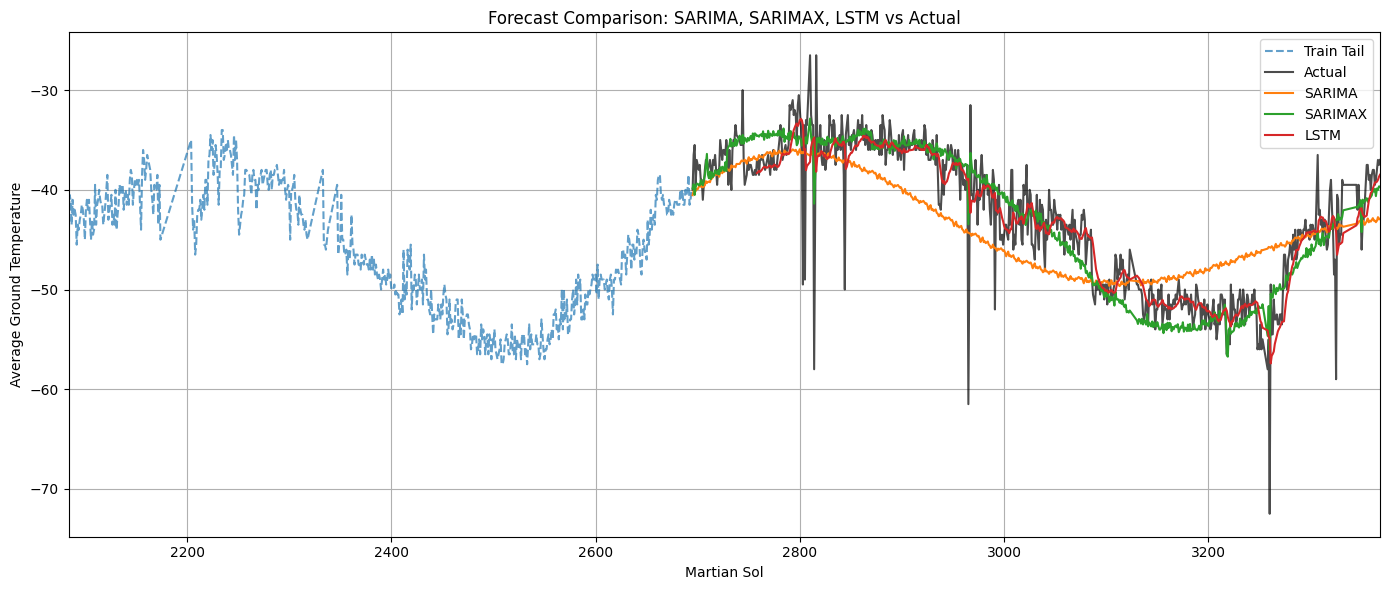

In [24]:
plt.figure(figsize=(14,6))
# Plot training tail
plt.plot(train_index[2000:], train_data['avg_ground_temp'].iloc[2000:], label="Train Tail", alpha=0.7, linestyle='--')
plt.plot(test_index, test_data['avg_ground_temp'], label='Actual', color='black', alpha=0.7)
plt.plot(test_index, y_pred_sarima, label='SARIMA')
plt.plot(test_index, y_pred_sarimax, label='SARIMAX')
plt.plot(test_index[-len(y_pred_lstm):], y_pred_lstm, label='LSTM')
plt.title("Forecast Comparison: SARIMA, SARIMAX, LSTM vs Actual")
plt.xlabel("Martian Sol")
plt.ylabel("Average Ground Temperature")
plt.xlim(train_index[2000], test_index.max())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Anamoly Detection with Hybrid Models

---

### 4.1 Building and Training Models

In [25]:
# Configure residuals for Hybrid
# --- SARIMA --- 
r1 = y_true_sarima - y_pred_sarima
r1 = r1.reshape(-1,1) # SARIMA

s1 = StandardScaler()
r1_scaled = s1.fit_transform(r1)

# --- SARIMAX ---
r2 = y_true_sarimax - y_pred_sarimax
r2 = r2.reshape(-1,1)

s2 = StandardScaler()
r2_scaled = s2.fit_transform(r2)

In [26]:
# Define sequence length
seq_len = 30
batch_size = 32

# --- SARIMA Based ---
r1_seq_gen = AutoencoderSequenceGenerator(r1_scaled, 
                                          seq_len=seq_len, 
                                          batch_size=batch_size)
print("Number of training sequences")
print("___" * 10)
print(f"SARIMA BASED: {len(r1_seq_gen)}")
print("---" * 10)

# --- SARIMAX Based ---
r2_seq_gen = AutoencoderSequenceGenerator(r2_scaled, 
                                          seq_len=seq_len, 
                                          batch_size=batch_size)
print(f"SARIMAX BASED: {len(r2_seq_gen)}")
print("___" * 10)

Number of training sequences
______________________________
SARIMA BASED: 20
------------------------------
SARIMAX BASED: 20
______________________________


In [27]:
# Define input dimensions
n_features = 1  # Residual is 1D
epochs = 20

# --- Build models ---
lstm_auto_sarima  = create_lstm_autoencoder(seq_len, n_features)
lstm_auto_sarimax = create_lstm_autoencoder(seq_len, n_features)

In [28]:
# Instantiate the callback
tqdm_callback = TQDMProgressBar()

# --- Train SARIMA-based Autoencoder ---
print("Training SARIMA-based LSTM autoencoder...")
history_sarima = lstm_auto_sarima.fit(
    r1_seq_gen,
    epochs=epochs,
    verbose=0,
    callbacks=[tqdm_callback]
)

print("___" * 20)

# --- Train SARIMAX-based Autoencoder ---
print("\nTraining SARIMAX-based LSTM autoencoder...")
history_sarimax = lstm_auto_sarimax.fit(
    r2_seq_gen,
    epochs=epochs,
    verbose=0,
    callbacks=[tqdm_callback]
)

Training SARIMA-based LSTM autoencoder...


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

____________________________________________________________

Training SARIMAX-based LSTM autoencoder...


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

### 4.2 Detecting Anamolies

In [29]:
# SARIMA-based
print("")
print("SARIMA BASED")
print("---" * 40)
errors_sarima = compute_reconstruction_errors(lstm_auto_sarima, r1_seq_gen)

print("___" * 40)
print("")

# SARIMAX-based
print("SARIMAX BASED")
print("---" * 40)
errors_sarimax = compute_reconstruction_errors(lstm_auto_sarimax, r2_seq_gen)


SARIMA BASED
------------------------------------------------------------------------------------------------------------------------


Computing reconstruction errors:   0%|          | 0/20 [00:00<?, ?it/s]

________________________________________________________________________________________________________________________

SARIMAX BASED
------------------------------------------------------------------------------------------------------------------------


Computing reconstruction errors:   0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# Detect anomalies
anoms_sarima, thresh_sarima = detect_anomalies(errors_sarima)
anoms_sarimax, thresh_sarimax = detect_anomalies(errors_sarimax)

# Convert boolean flags to integer indices (relative to error series)
anom_indices_sarima  = np.where(anoms_sarima == 1)[0]
anom_indices_sarimax = np.where(anoms_sarimax == 1)[0]

# Generate sol numbers starting from beginning of test set
sol_offset = test_index[0]
sols = np.arange(sol_offset + seq_len, sol_offset + seq_len + len(errors_sarima))

# Map these to sol numbers using offset + seq_len
anomalous_sols_sarima  = sols[anom_indices_sarima]
anomalous_sols_sarimax = sols[anom_indices_sarimax]

# Safety check: ensure the anomaly sols exist in test_data
valid_anom_sarima = [sol for sol in anomalous_sols_sarima if sol in test_data.index]
valid_anom_sarimax = [sol for sol in anomalous_sols_sarimax if sol in test_data.index]


# Inspect
print(f"SARIMA Hybrid Anomalous Sols: {anomalous_sols_sarima} ... ({len(anomalous_sols_sarima)} total)")
print(f"SARIMAX Hybrid Anomalous Sols: {anomalous_sols_sarimax} ... ({len(anomalous_sols_sarimax)} total)")

# Save for later
#np.save("model_outputs/anom_sols_sarima.npy", anomalous_sols_sarima)
#np.save("model_outputs/anom_sols_sarimax.npy", anomalous_sols_sarimax)

SARIMA Hybrid Anomalous Sols: [2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823
 2824 2825 2826 2827 2828 2829 2830 3262 3263 3264 3265 3266 3267 3268
 3269 3270 3271] ... (31 total)
SARIMAX Hybrid Anomalous Sols: [2803 2804 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821
 2822 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832 2839 2989 3316
 3323 3324 3325] ... (31 total)


In [39]:
# Align anomaly detections into a comparison matrix
anomaly_flags_df = pd.DataFrame(index=sols)
anomaly_flags_df["SARIMA_AE"]  = anoms_sarima
anomaly_flags_df["SARIMAX_AE"] = anoms_sarimax

# Count overlap or mismatches
anomaly_flags_df["Overlap"] = anomaly_flags_df.sum(axis=1)
anomaly_flags_df["Overlap_Label"] = anomaly_flags_df["Overlap"].map({0: "None", 1: "Single", 2: "Both"})

# View overlapping anomalies
anomaly_flags_df[anomaly_flags_df["Overlap"] == 2]

,SARIMA_AE,SARIMAX_AE,Overlap,Overlap_Label
2810,1,1,2,Both
2811,1,1,2,Both
2812,1,1,2,Both
2813,1,1,2,Both
2814,1,1,2,Both
2815,1,1,2,Both
2816,1,1,2,Both
2817,1,1,2,Both
2818,1,1,2,Both
2819,1,1,2,Both


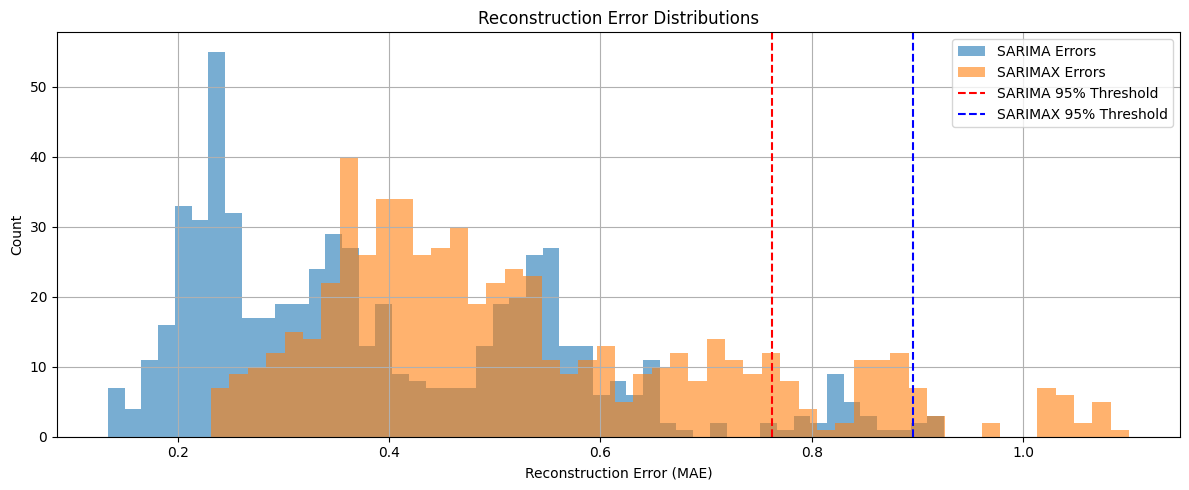

In [32]:
plt.figure(figsize=(12, 5))
plt.hist(errors_sarima, bins=50, alpha=0.6, label='SARIMA Errors')
plt.hist(errors_sarimax, bins=50, alpha=0.6, label='SARIMAX Errors')
plt.axvline(np.percentile(errors_sarima, 95), color='red', linestyle='--', label='SARIMA 95% Threshold')
plt.axvline(np.percentile(errors_sarimax, 95), color='blue', linestyle='--', label='SARIMAX 95% Threshold')
plt.title("Reconstruction Error Distributions")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

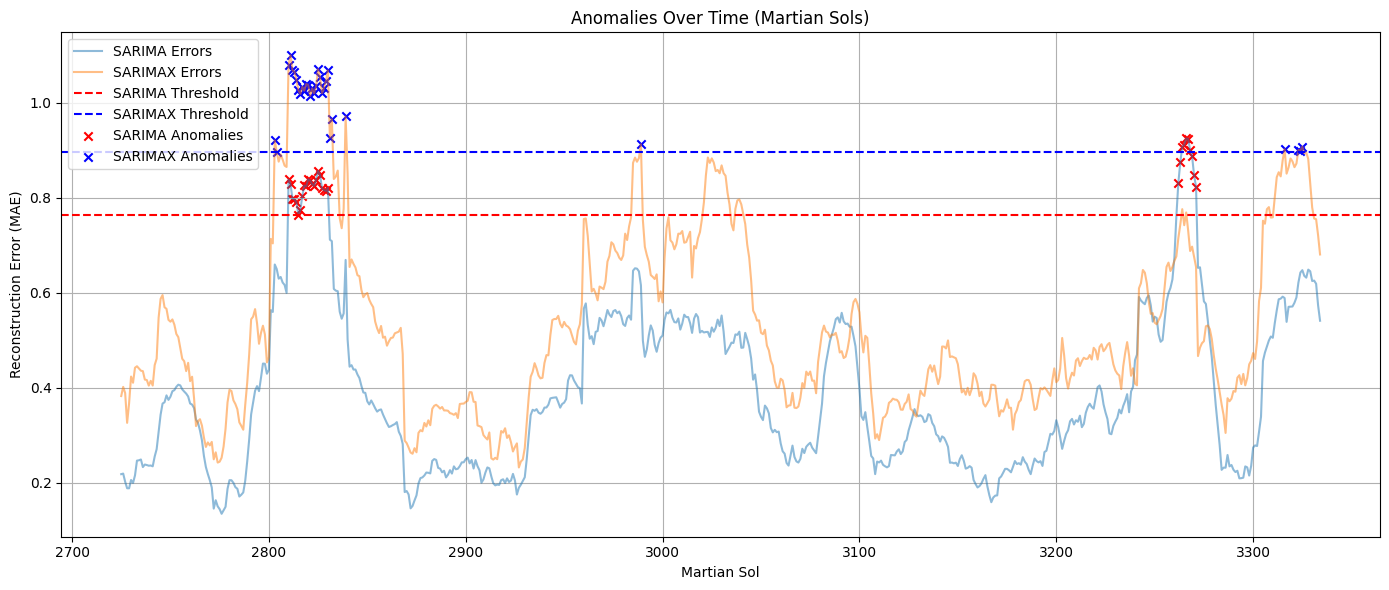

In [33]:
plt.figure(figsize=(14, 6))

# Plot error curves
plt.plot(sols, errors_sarima, label='SARIMA Errors', alpha=0.5)
plt.plot(sols, errors_sarimax, label='SARIMAX Errors', alpha=0.5)

# Threshold lines
plt.axhline(thresh_sarima, color='red', linestyle='--', label='SARIMA Threshold')
plt.axhline(thresh_sarimax, color='blue', linestyle='--', label='SARIMAX Threshold')

# Anomalies as points
plt.scatter(sols[anoms_sarima == 1], errors_sarima[anoms_sarima == 1], color='red', marker='x', label='SARIMA Anomalies')
plt.scatter(sols[anoms_sarimax == 1], errors_sarimax[anoms_sarimax == 1], color='blue', marker='x', label='SARIMAX Anomalies')

# Labels and formatting
plt.title("Anomalies Over Time (Martian Sols)")
plt.xlabel("Martian Sol")
plt.ylabel("Reconstruction Error (MAE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

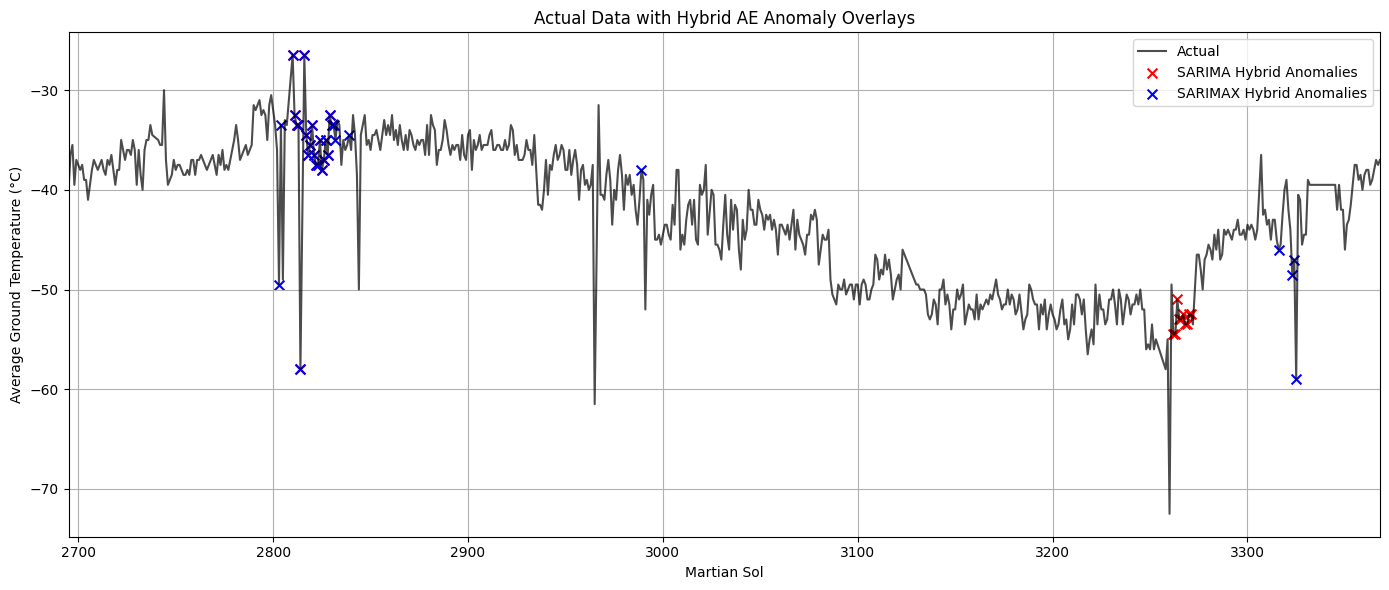

In [34]:
plt.figure(figsize=(14,6))

# Plot training tail
#plt.plot(train_index[2400:], train_data['avg_ground_temp'].iloc[2400:], label="Train Tail", alpha=0.5, linestyle='--')

# Plot actual test data
plt.plot(test_index, test_data['avg_ground_temp'], label='Actual', color='black', alpha=0.7)

# Plot Hybrid AE anomalies
plt.scatter(valid_anom_sarima,
            test_data.loc[valid_anom_sarima, 'avg_ground_temp'],
            color='red', marker='x', s=50, label='SARIMA Hybrid Anomalies')

plt.scatter(valid_anom_sarimax,
            test_data.loc[valid_anom_sarimax, 'avg_ground_temp'],
            color='blue', marker='x', s=50, label='SARIMAX Hybrid Anomalies')

plt.title("Actual Data with Hybrid AE Anomaly Overlays")
plt.xlabel("Martian Sol")
plt.ylabel("Average Ground Temperature (°C)")
plt.xlim(test_index.min(), test_index.max())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 5. Model Performance Evaluation

### 5.1 Forecast Models

In [35]:
def trend_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100

# ── Compute SARIMA and SARIMAX Metrics ──────────
mae_sarima = metrics_sarima['mae']
mae_sarimax = metrics_sarimax['mae']

rmse_sarima = metrics_sarima['rmse']
rmse_sarimax = metrics_sarimax['rmse']

smape_sarima = smape(test_data['avg_ground_temp'], y_pred_sarima)
smape_sarimax = smape(test_data['avg_ground_temp'], y_pred_sarimax)

dir_acc_sarima = trend_directional_accuracy(test_data['avg_ground_temp'], y_pred_sarima)
dir_acc_sarimax = trend_directional_accuracy(test_data['avg_ground_temp'], y_pred_sarimax)

# ── LSTM Metrics from JSON ───────────────────────
mae_lstm   = metrics_lstm['mae']
rmse_lstm  = metrics_lstm['rmse']
smape_lstm = metrics_lstm['smape']
dir_acc_lstm = metrics_lstm['Dir. Accuracy ']

# ── Assemble Metrics DataFrame ──────────────────
comparison_df = pd.DataFrame({
    "MAE": [mae_sarima, mae_sarimax, mae_lstm],
    "RMSE": [rmse_sarima, rmse_sarimax, rmse_lstm],
    "sMAPE": [smape_sarima, smape_sarimax, smape_lstm],
    "Directional Accuracy": [dir_acc_sarima, dir_acc_sarimax, dir_acc_lstm],
}, index=["SARIMA", "SARIMAX", "LSTM"])

comparison_df.head()

,MAE,RMSE,sMAPE,Directional Accuracy
SARIMA,3.569977,4.524491,8.326217,43.974961
SARIMAX,2.097347,2.913488,4.912609,50.234742
LSTM,1.768408,2.939169,4.162601,49.655172


### 5.2 Anamoly Detection Models

In [36]:
# Collect autoencoder error statistics into a dictionary
ae_metrics = {
    "Metric": ["Mean Error", "Median Error", "95th Percentile", "Max Error", "Std Deviation"],
    "SARIMA AE": [
        np.mean(errors_sarima),
        np.median(errors_sarima),
        np.percentile(errors_sarima, 95),
        np.max(errors_sarima),
        np.std(errors_sarima)
    ],
    "SARIMAX AE": [
        np.mean(errors_sarimax),
        np.median(errors_sarimax),
        np.percentile(errors_sarimax, 95),
        np.max(errors_sarimax),
        np.std(errors_sarimax)
    ]
}

# Convert to DataFrame
ae_comparison_df = pd.DataFrame(ae_metrics)
ae_comparison_df.set_index("Metric", inplace=True)


# Round for clean presentation
ae_comparison_df = ae_comparison_df.round(4)

# Display the result
ae_comparison_df

,SARIMA AE,SARIMAX AE
Metric,,
Mean Error,0.3924,0.5308
Median Error,0.3493,0.4740
95th Percentile,0.7628,0.8958
Max Error,0.9252,1.1002
Std Deviation,0.1730,0.1947


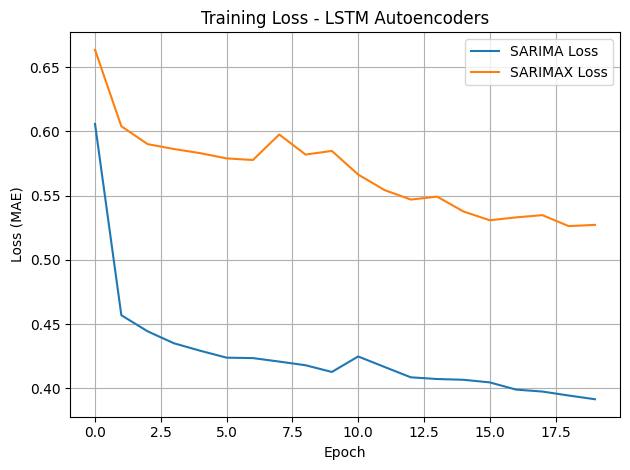

In [37]:
plt.plot(history_sarima.history['loss'], label='SARIMA Loss')
plt.plot(history_sarimax.history['loss'], label='SARIMAX Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("Training Loss - LSTM Autoencoders")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 6. Final Modeling Summary: Forecasting and Hybrid Anomaly Detection

This section summarizes the evaluation and selection of forecasting models (LSTM vs. SARIMAX) and the subsequent application of LSTM-based autoencoders for anomaly detection on model residuals.

---

### Forecast Model Evaluation: LSTM vs SARIMAX
 
Two models were evaluated for forecasting average Martian ground temperature:

- **LSTM (Long Short-Term Memory Neural Network)**: A deep learning model capable of capturing nonlinear temporal patterns.
- **SARIMAX (Seasonal ARIMA with eXogenous variables)**: A statistical time series model that integrates domain variables such as UV index and atmospheric pressure.

#### Forecasting Performance

| Model     | MAE    | RMSE   | sMAPE  | Directional Accuracy (%)   |
|-----------|--------|--------|--------|----------------------------|
| **LSTM**    | **1.77** | 2.94 | **4.16** | 49.66              |
| **SARIMAX** | 2.10   | **2.91**   | 4.91  | **50.23**                 |

LSTM demonstrated superior performance on 2 out of 3 error metrics, while SARIMAX marginally outperformed in directional trend accuracy. Both models are valid depending on the deployment context.

#### Model Trade-off Summary

| Dimension                  | **LSTM**                                  | **SARIMAX**                                 |
|----------------------------|-------------------------------------------|---------------------------------------------|
| Forecast Accuracy          | Highest overall                           | Good, significantly better than baseline    |
| Directional Accuracy       | Strong (via classification head)          | Highest, trend-aware                        |
| Interpretability           | Black-box                                 | Transparent, coefficient-based              |
| Feature Attribution        | Implicit (learned)                        | Explicit exogenous feature modeling         |
| Deployment Complexity      | Requires deep learning stack              | Lightweight, minimal infrastructure         |
| Scientific Use Case Fit    | Pattern-driven exploratory models         | Well-suited for explainable applications    |

---

### Forecast Model Recommendation

- **Choose LSTM** when raw predictive performance is the priority, particularly in exploratory or autonomous environments.
- **Choose SARIMAX** when model transparency, scientific validation, or operational stability is required.
- **Use both in tandem** for a balanced approach: SARIMAX as a dependable forecasting baseline, and LSTM as an enhanced modeling layer.

---

### Hybrid Anomaly Detection: SARIMA AE vs SARIMAX AE

To identify unexpected or hard-to-model phenomena in the Martian environment, LSTM-based autoencoders were trained to reconstruct the residuals of both SARIMA and SARIMAX forecasts.

#### Reconstruction Error Metrics

| Metric              | SARIMA AE | SARIMAX AE |
|---------------------|-----------|------------|
| Mean Error (MAE)    | **0.3924** | 0.5308      |
| Median Error        | **0.3493** | 0.4740      |
| 95th Percentile     | **0.7628** | 0.8958      |
| Max Error           | 0.9252     | **1.1002**  |
| Std. Deviation      | **0.1730** | 0.1947      |

SARIMA AE exhibited overall better reconstruction fidelity, suggesting more consistent and structured residual patterns. SARIMAX AE showed slightly higher error peaks, potentially reflecting sensitivity to subtle nonlinear interactions.

#### Anomaly Detection Results

- **Anomalies detected**:
  - SARIMA AE: 31 sols
  - SARIMAX AE: 31 sols
- **Overlap**: 21 sols identified by both models

This overlap indicates consistent core anomaly detection between the models, while model-specific anomalies provide additional exploratory leads.

#### Interpretation

- **SARIMA AE** appears more **precise**, flagging fewer, sharper anomaly clusters.
- **SARIMAX AE** may be more **sensitive**, capturing broader but potentially noisier deviations.
- Using both models enhances coverage and confidence in detecting non-obvious atmospheric shifts or instrumentation irregularities.

---

### Hybrid Strategy Summary

> The combination of interpretable forecasting with statistical models (SARIMAX) and data-driven anomaly detection (LSTM AEs) enables a layered understanding of environmental behavior on Mars.

- **SARIMAX** provides explainable forecasts and robust temporal modeling using exogenous variables.
- **LSTM** models offer superior predictive accuracy and support post-hoc anomaly detection.
- **LSTM Autoencoders**, trained on forecast residuals, enhance the system’s ability to flag unusual conditions without requiring pre-labeled data.

This hybrid system balances interpretability, precision, and responsiveness — suitable for both retrospective analysis and potential autonomous use in resource-constrained exploratory missions.